In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq


#os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


llm=ChatGroq(model="llama-3.1-8b-instant")
#llm = ChatOpenAI(model="gpt-4o")
result=llm.invoke("Hello")
result

AIMessage(content='Hello. How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 36, 'total_tokens': 46, 'completion_time': 0.151002218, 'prompt_time': 0.003858959, 'queue_time': 0.063122871, 'total_time': 0.154861177}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_ff2b098aaf', 'finish_reason': 'stop', 'logprobs': None}, id='run-eb6f7214-0230-4d3b-bbb4-d66f6eb2aec8-0', usage_metadata={'input_tokens': 36, 'output_tokens': 10, 'total_tokens': 46})

In [9]:
from youtube_transcript_api import YouTubeTranscriptApi
from IPython.display import Image, display

from typing import TypedDict, Optional
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph,END
from langgraph.prebuilt import tools_condition, ToolNode
from youtube_transcript_api.proxies import WebshareProxyConfig
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

class State(TypedDict):
    video_url: str
    transcript: str
    blog: str
    feedback:str
    final_blog: str

def extract_transcript(state: State) -> State:

    """Extracts transcript from a YouTube video URL."""

    if "video_url" not in state:
        raise KeyError("Missing 'video_url' in state.")
    video_id = state["video_url"].split("v=")[-1]  # Extract video ID


    # transcript = YouTubeTranscriptApi.fetch(video_id=video_id)

    transcript_api = YouTubeTranscriptApi()
    # (proxy_config=WebshareProxyConfig(
    #     proxy_username="azvbpyuw-rotate",
    #     proxy_password="cu4sn15p5xek"))
    transcript= transcript_api.fetch(video_id=video_id)
    # print("Transcript: ",transcript)
    # for snippet in transcript:
    #     print(snippet.text)
    text_transcript = " ".join(snippet.text for snippet in transcript)
    # FetchedTranscript(snippets=[FetchedTranscriptSnippet(text='if you work in Tech or in anything', start=0.0, duration=3.78), FetchedTranscriptSnippet(text="adjacent attack you've probably heard", start=2.159, duration=3.841), FetchedTranscriptSnippet(text='the abbreviation API being thrown around', start=3.78, duration=4.859), FetchedTranscriptSnippet(text="so let's talk about apis what are they", 
    


    # text_transcript = " ".join([t["text"] for t in transcript])
    state["transcript"] = text_transcript
    print("******Transcript Extracted*******")
    return state

def chunk_text(text: str, max_tokens: int = 500):

    """Splits text into chunks of max_tokens words."""

    words = text.split()
    chunks = []
    for i in range(0, len(words), max_tokens):
        chunks.append(" ".join(words[i:i + max_tokens]))
    return chunks

def generate_blog_section(chunk: str) -> str:

    """Generates a blog section for a given transcript chunk."""

    # prompt_text = f"""
    #     You are a professional blog writer skilled in writing engaging, informative, and SEO-friendly articles.
    #     Convert the following YouTube transcript chunk into a well-structured blog section:
        
    #     {chunk}
        
    #     Ensure it is engaging and easy to read.
    # """
    prompt_text = f"""
        Extract the key technical or narrative points from this transcript chunk 
        and format them as detailed blog headings and paragraphs:
        {chunk}
        
        Do not include a Title or Introduction yet. Focus only on the facts in this chunk.
    """

    return llm.invoke(prompt_text).content  # Invoke LLM for each chunk

def generate_blog(state: State) -> State:

    """Generates a full blog by processing transcript chunks separately."""
    
    transcript_chunks = chunk_text(state["transcript"])  # Split transcript
    blog_sections = [generate_blog_section(chunk) for chunk in transcript_chunks]  # Process chunks

    combined_body = "\n\n".join(blog_sections)
    final_polish_prompt = f"""
        You are a professional blog editor. Take the following sections and 
        turn them into one cohesive blog post with ONE compelling title, 
        ONE introduction, well-organized subheadings, and ONE conclusion.
        
        Content:
        {combined_body}
    """
    # state["blog"] = "\n\n".join(final_polish_prompt)  # Combine sections
    state["blog"] = llm.invoke(final_polish_prompt).content
    return state
    


def human_feedback(state: State) -> dict:
    print("\n-------------------------------------------✅ Blog Draft ------------------------------------ \n", state["blog"])
    print("\n-------------------------------------------✅ End of the Blog------------------------------------ \n")
    choice = input("\nDo you want to provide feedback to refine the blog? (yes/no/accepted): ").strip().lower()
    
    if choice == "yes":
        state["feedback"] = input("\nEnter your feedback to refine the blog: ")
        return {"feedback": state["feedback"], "refine_blog": state["blog"]}
    elif choice == "accepted":
        state["feedback"] = "Accepted"
        print("\n------------------------------------ Blog Accepted ----------------------------------------------\n")
        return {"feedback": state["feedback"],"final_blog":state["blog"]}  # Ends workflow
    else:
        state["feedback"] = "No feedback provided."
        print("\n------------------------------------ No feedback provided.---------------------------------------------- \n")
        return {"feedback": state["feedback"],"final_blog":state["blog"]}  # Ends workflow

def refine_blog(state: State, llm) -> dict:
    
    feedback = state.get("feedback", "No human feedback provided.")
    print("\n---------------------------------- Feedback : -------------------------------------------- \n", feedback)
    
    prompt = f"Revise the blog considering following feedback provided from user : {feedback}\n\n Blog Content: {state['blog']}"

    print("\n\n\n ---------------------- Refining blog as per the following feedback : ",feedback,"--------------------------------")
    # Call LLM to refine the blog
    final_blog = llm.invoke(prompt).content
    state["final_blog"] = final_blog
    print("\n Blog refined Successfully !\n")
    return {
        "blog": final_blog,    # Update the blog with the refined version
        "final_blog": final_blog  # Store the final blog version
    }

# Conditional edges for feedback loop
def route_after_feedback(state):
    if state["feedback"] == "Accepted" or state["feedback"] == "No feedback provided.":
        print("\n✅ Blog Finalized Successfully!\n")
        return END  # Ends workflow if feedback is accepted or no feedback is given
    return "refine_blog"  # Loops back to refining



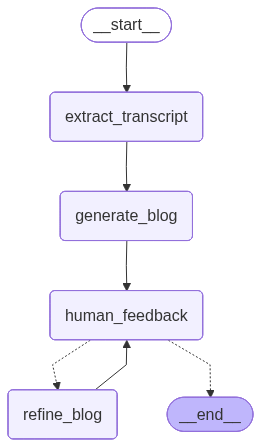

In [10]:
# builder = StateGraph(State)
# builder.add_node("extract_transcript", extract_transcript)
# builder.add_node("generate_blog", generate_blog)

# builder.add_edge(START, "extract_transcript")
# builder.add_edge("extract_transcript", "generate_blog")
# builder.add_edge("generate_blog",END)

# graph = builder.compile()

# display(Image(graph.get_graph().draw_mermaid_png()))

def generate_graph(llm):
    builder = StateGraph(State)
       
    builder.add_node("extract_transcript", extract_transcript)
    builder.add_node("generate_blog", generate_blog)
    builder.add_node("human_feedback", human_feedback)
    builder.add_node("refine_blog", lambda state: refine_blog(state, llm)) 

    builder.add_edge(START, "extract_transcript")
    builder.add_edge("extract_transcript", "generate_blog")
    builder.add_edge("generate_blog", "human_feedback")
    builder.add_edge("refine_blog", "human_feedback")  # ✅ Loop back to get more feedback if needed

    # Conditional edge based on feedback
    # builder.add_conditional_edges("human_feedback", refine_blog, ["generate_blog",END])
    # builder.add_conditional_edges(
    #     "human_feedback",
    #     lambda state: "refine_blog" if state.get("feedback") != "No feedback provided." else "END"
    # )
    builder.add_conditional_edges("human_feedback", route_after_feedback, ["refine_blog", END])
    graph = builder.compile()
    display(Image(graph.get_graph().draw_mermaid_png()))
    return graph

graph=generate_graph(llm)
print(graph)


In [12]:
# url="https://www.youtube.com/watch?v=bxuYDT-BWaI" ##mention any url here 
url= input()
initial_state: State = {
        "video_url": url,
        "transcript": "",
        "blog": "",
        "feedback": "",  # No need to store permanently
        "final_blog":""
    }
# Thread
messages= graph.invoke(initial_state)

# Ensure the final blog is printed correctly
if "final_blog" in messages:
    print("\n------------------------------------ ✅ Final Blog Output: ------------------------------------ \n", messages["final_blog"])
else:
    print("\n❌ Error: 'final_blog' key missing in output state.")


******Transcript Extracted*******

-------------------------------------------✅ Blog Draft ------------------------------------ 
 **Unlocking the Power of APIs: Understanding the Fundamentals and Applications**

The world of software development has never been more interconnected. Behind the scenes, Application Programming Interfaces (APIs) enable different systems and applications to communicate with each other seamlessly. In this article, we'll delve into the basics of APIs, their importance, and how they work.

**What is an API and Why Do We Need Them?**

An API stands for Application Programming Interface, a contract or protocol that dictates how two applications communicate with each other using requests and responses. Think of an API as a customer service representative at a restaurant, where you can make requests and receive responses without having to navigate the complexities of how the restaurant works. APIs are essential because they allow us to access specific functionality